## 选择模型

简介：U-Net网络结构是一个基于FCN并改进后的深度学习网络，包含下采样（编码器，特征提取）和上采样（解码器，分辨率还原）两个阶段，因模型结构比较像U型而命名为U-Net。

初始化环境

In [1]:
import os
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PilImage

import paddle
from paddle.nn import functional as F

import warnings
warnings.filterwarnings('ignore') 

paddle.__version__

'2.2.2'

In [2]:
#配置数据集
!unzip -q 'data/data75217/doves.zip' -d work/doves

In [2]:

#查看数据集目录
#数据集解压后，里面放的每个文件夹中有四个文件，分别是图片文件、标签文件、标签名字文件和可视化的图片文件。
!tree /home/aistudio/work/doves

/home/aistudio/work/doves
├── IMG_4674
│   ├── img.png
│   ├── label_names.txt
│   ├── label.png
│   └── label_viz.png
├── IMG_4675
│   ├── img.png
│   ├── label_names.txt
│   ├── label.png
│   └── label_viz.png
├── IMG_4676
│   ├── img.png
│   ├── label_names.txt
│   ├── label.png
│   └── label_viz.png
├── IMG_4677
│   ├── img.png
│   ├── label_names.txt
│   ├── label.png
│   └── label_viz.png
├── IMG_4678
│   ├── img.png
│   ├── label_names.txt
│   ├── label.png
│   └── label_viz.png
├── IMG_4679
│   ├── img.png
│   ├── label_names.txt
│   ├── label.png
│   └── label_viz.png
├── IMG_4680
│   ├── img.png
│   ├── label_names.txt
│   ├── label.png
│   └── label_viz.png
├── IMG_4681
│   ├── img.png
│   ├── label_names.txt
│   ├── label.png
│   └── label_viz.png
├── IMG_4682
│   ├── img.png
│   ├── label_names.txt
│   ├── label.png
│   └── label_viz.png
├── IMG_4683
│   ├── img.png
│   ├── label_names.txt
│   ├── label.png
│   └── label_viz.png
├── IMG_4684
│   ├── img.png
│   ├── label_n

In [3]:
#查看样本数量
images_path = "work/doves"
image_count = len([os.path.join(images_path, image_name) 
          for image_name in os.listdir(images_path)])
print("用于训练的图片样本数量:", image_count)

用于训练的图片样本数量: 124


## 配置超参数并训练模型

In [4]:
#划分训练集
def _sort_images(image_dir):
    """
    对文件夹内的图像进行按照文件名排序
    """
    images = []
    labels = []

    for image_name in os.listdir(image_dir):
        if os.path.isdir(os.path.join(image_dir, image_name)):
            images.append(os.path.join(os.path.join(image_dir, image_name), 'img.png'))
            labels.append(os.path.join(os.path.join(image_dir, image_name), 'label.png'))

    return sorted(images), sorted(labels)

def write_file(mode, images, labels):
    with open('./{}.txt'.format(mode), 'w') as f:
        for i in range(len(images)):
            f.write('{}\t{}\n'.format(images[i], labels[i]))

In [5]:
#对原始的数据集进行整理，得到数据集和标签两个数组，分别一一对应，这样可以在使用的时候能够很方便的找到原始数据和标签的对应关系。
images, labels = _sort_images(images_path)
eval_num = int(image_count * 0.15)

In [6]:
#测试&验证数据集
write_file('train', images[:-eval_num], labels[:-eval_num])
write_file('test', images[-eval_num:], labels[-eval_num:])
write_file('eval', images[-eval_num:], labels[-eval_num:])

### 数据集展示、测试
划分好数据集之后，来查验一下数据集是否符合预期，我们通过划分的配置文件读取图片路径后再加载图片数据来用matplotlib进行展示。

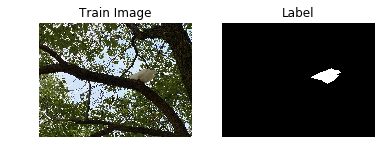

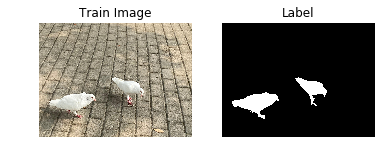

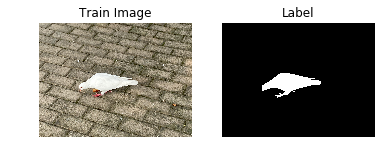

In [7]:
with open('./train.txt', 'r') as f:
    i = 0

    for line in f.readlines():
        image_path, label_path = line.strip().split('\t')
        image = np.array(PilImage.open(image_path))
        label = np.array(PilImage.open(label_path))
    
        if i > 2:
            break
        # 进行图片的展示
        plt.figure()

        plt.subplot(1,2,1), 
        plt.title('Train Image')
        plt.imshow(image.astype('uint8'))
        plt.axis('off')

        plt.subplot(1,2,2), 
        plt.title('Label')
        plt.imshow(label.astype('uint8'), cmap='gray')
        plt.axis('off')

        plt.show()
        i = i + 1

### 数据集类定义
// 飞桨（PaddlePaddle）数据集加载方案是统一使用Dataset（数据集定义） + DataLoader（多进程数据集加载）。 

数据集定义主要是实现一个新的Dataset类，继承父类paddle.io.Dataset，并实现父类中以下两个抽象方法，getitem__和__len

In [8]:
import random

from paddle.io import Dataset
from paddle.vision.transforms import transforms as T


class PetDataset(Dataset):
    """
    数据集定义
    """
    def __init__(self, mode='train'):
        """
        构造函数
        """
        self.image_size = IMAGE_SIZE
        self.mode = mode.lower()
        
        assert self.mode in ['train', 'test', 'predict'], \
            "mode should be 'train' or 'test' or 'predict', but got {}".format(self.mode)
        
        self.train_images = []
        self.label_images = []

        with open('./{}.txt'.format(self.mode), 'r') as f:
            for line in f.readlines():
                image, label = line.strip().split('\t')
                self.train_images.append(image)
                self.label_images.append(label)
        
    def _load_img(self, path, color_mode='rgb', transforms=[]):
        """
        统一的图像处理接口封装，用于规整图像大小和通道
        """
        with open(path, 'rb') as f:
            img = PilImage.open(io.BytesIO(f.read()))
            if color_mode == 'grayscale':
                # if image is not already an 8-bit, 16-bit or 32-bit grayscale image
                # convert it to an 8-bit grayscale image.
                if img.mode not in ('L', 'I;16', 'I'):
                    img = img.convert('L')
            elif color_mode == 'rgba':
                if img.mode != 'RGBA':
                    img = img.convert('RGBA')
            elif color_mode == 'rgb':
                if img.mode != 'RGB':
                    img = img.convert('RGB')
            else:
                raise ValueError('color_mode must be "grayscale", "rgb", or "rgba"')
            
            return T.Compose([
                T.Resize(self.image_size)
            ] + transforms)(img)

    def __getitem__(self, idx):
        """
        返回 image, label
        """
        train_image = self._load_img(self.train_images[idx], 
                                     transforms=[
                                         T.Transpose(), 
                                         T.Normalize(mean=127.5, std=127.5)
                                     ]) # 加载原始图像
        label_image = self._load_img(self.label_images[idx], 
                                     color_mode='grayscale',
                                     transforms=[T.Grayscale()]) # 加载Label图像
    
        # 返回image, label
        train_image = np.array(train_image, dtype='float32')
        label_image = np.array(label_image, dtype='int64')
        return train_image, label_image
        
    def __len__(self):
        """
        返回数据集总数
        """
        return len(self.train_images)

### 模型组网
我们为了减少卷积操作中的训练参数来提升性能，是继承paddle.nn.Layer自定义了一个SeparableConv2D Layer类，

整个过程是把filter_size * filter_size * num_filters的Conv2D操作拆解为两个子Conv2D，先对输入数据的每个通道使用filter_size * filter_size * 1的卷积核进行计算，

输入输出通道数目相同，之后在使用1 * 1 * num_filters的卷积核计算。

In [9]:
from paddle.nn import functional as F

class SeparableConv2D(paddle.nn.Layer):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 kernel_size, 
                 stride=1, 
                 padding=0, 
                 dilation=1, 
                 groups=None, 
                 weight_attr=None, 
                 bias_attr=None, 
                 data_format="NCHW"):
        super(SeparableConv2D, self).__init__()

        self._padding = padding
        self._stride = stride
        self._dilation = dilation
        self._in_channels = in_channels
        self._data_format = data_format

        # 第一次卷积参数，没有偏置参数
        filter_shape = [in_channels, 1] + self.convert_to_list(kernel_size, 2, 'kernel_size')
        self.weight_conv = self.create_parameter(shape=filter_shape, attr=weight_attr)

        # 第二次卷积参数
        filter_shape = [out_channels, in_channels] + self.convert_to_list(1, 2, 'kernel_size')
        self.weight_pointwise = self.create_parameter(shape=filter_shape, attr=weight_attr)
        self.bias_pointwise = self.create_parameter(shape=[out_channels], 
                                                    attr=bias_attr, 
                                                    is_bias=True)
    
    def convert_to_list(self, value, n, name, dtype=np.int):
        if isinstance(value, dtype):
            return [value, ] * n
        else:
            try:
                value_list = list(value)
            except TypeError:
                raise ValueError("The " + name +
                                "'s type must be list or tuple. Received: " + str(
                                    value))
            if len(value_list) != n:
                raise ValueError("The " + name + "'s length must be " + str(n) +
                                ". Received: " + str(value))
            for single_value in value_list:
                try:
                    dtype(single_value)
                except (ValueError, TypeError):
                    raise ValueError(
                        "The " + name + "'s type must be a list or tuple of " + str(
                            n) + " " + str(dtype) + " . Received: " + str(
                                value) + " "
                        "including element " + str(single_value) + " of type" + " "
                        + str(type(single_value)))
            return value_list
    
    def forward(self, inputs):
        conv_out = F.conv2d(inputs, 
                            self.weight_conv, 
                            padding=self._padding,
                            stride=self._stride,
                            dilation=self._dilation,
                            groups=self._in_channels,
                            data_format=self._data_format)
        
        out = F.conv2d(conv_out,
                       self.weight_pointwise,
                       bias=self.bias_pointwise,
                       padding=0,
                       stride=1,
                       dilation=1,
                       groups=1,
                       data_format=self._data_format)

        return out

### 定义Encoder编码器

我们将网络结构中的Encoder下采样过程进行了一个Layer封装，方便后续调用，减少代码编写，下采样是有一个模型逐渐向下画曲线的一个过程，这个过程中是不断的重复一个单元结构将通道数不断增加，

形状不断缩小，并且引入残差网络结构，我们将这些都抽象出来进行统一封装。

In [10]:
class Encoder(paddle.nn.Layer):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        
        self.relus = paddle.nn.LayerList(
            [paddle.nn.ReLU() for i in range(2)])
        self.separable_conv_01 = SeparableConv2D(in_channels, 
                                                 out_channels, 
                                                 kernel_size=3, 
                                                 padding='same')
        self.bns = paddle.nn.LayerList(
            [paddle.nn.BatchNorm2D(out_channels) for i in range(2)])
        
        self.separable_conv_02 = SeparableConv2D(out_channels, 
                                                 out_channels, 
                                                 kernel_size=3, 
                                                 padding='same')
        self.pool = paddle.nn.MaxPool2D(kernel_size=3, stride=2, padding=1)
        self.residual_conv = paddle.nn.Conv2D(in_channels, 
                                              out_channels, 
                                              kernel_size=1, 
                                              stride=2, 
                                              padding='same')

    def forward(self, inputs):
        previous_block_activation = inputs
        
        y = self.relus[0](inputs)
        y = self.separable_conv_01(y)
        y = self.bns[0](y)
        y = self.relus[1](y)
        y = self.separable_conv_02(y)
        y = self.bns[1](y)
        y = self.pool(y)
        
        residual = self.residual_conv(previous_block_activation)
        y = paddle.add(y, residual)

        return y

### 定义Decoder解码器
在通道数达到最大得到高级语义特征图后，网络结构会开始进行decode操作，进行上采样，通道数逐渐减小，对应图片尺寸逐步增加， 直至恢复到原图像大小，那么这个过程里面也是通过不断的重复相同结构的残差网络完成，我们也是为了减少代码编写，将这个过程定义一个Layer来放到模型组网中使用。

In [11]:
class Decoder(paddle.nn.Layer):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()

        self.relus = paddle.nn.LayerList(
            [paddle.nn.ReLU() for i in range(2)])
        self.conv_transpose_01 = paddle.nn.Conv2DTranspose(in_channels, 
                                                           out_channels, 
                                                           kernel_size=3, 
                                                           padding=1)
        self.conv_transpose_02 = paddle.nn.Conv2DTranspose(out_channels, 
                                                           out_channels, 
                                                           kernel_size=3, 
                                                           padding=1)
        self.bns = paddle.nn.LayerList(
            [paddle.nn.BatchNorm2D(out_channels) for i in range(2)]
        )
        self.upsamples = paddle.nn.LayerList(
            [paddle.nn.Upsample(scale_factor=2.0) for i in range(2)]
        )
        self.residual_conv = paddle.nn.Conv2D(in_channels, 
                                              out_channels, 
                                              kernel_size=1, 
                                              padding='same')

    def forward(self, inputs):
        previous_block_activation = inputs

        y = self.relus[0](inputs)
        y = self.conv_transpose_01(y)
        y = self.bns[0](y)
        y = self.relus[1](y)
        y = self.conv_transpose_02(y)
        y = self.bns[1](y)
        y = self.upsamples[0](y)
        
        residual = self.upsamples[1](previous_block_activation)
        residual = self.residual_conv(residual)
        
        y = paddle.add(y, residual)
        
        return y

### 训练模型组网
按照U型网络结构格式进行整体的网络结构搭建，三次下采样，四次上采样。

In [12]:
class PetNet(paddle.nn.Layer):
    def __init__(self, num_classes):
        super(PetNet, self).__init__()

        self.conv_1 = paddle.nn.Conv2D(3, 32, 
                                       kernel_size=3,
                                       stride=2,
                                       padding='same')
        self.bn = paddle.nn.BatchNorm2D(32)
        self.relu = paddle.nn.ReLU()

        in_channels = 32
        self.encoders = []
        self.encoder_list = [64, 128, 256]
        self.decoder_list = [256, 128, 64, 32]

        # 根据下采样个数和配置循环定义子Layer，避免重复写一样的程序
        for out_channels in self.encoder_list:
            block = self.add_sublayer('encoder_{}'.format(out_channels),
                                      Encoder(in_channels, out_channels))
            self.encoders.append(block)
            in_channels = out_channels

        self.decoders = []

        # 根据上采样个数和配置循环定义子Layer，避免重复写一样的程序
        for out_channels in self.decoder_list:
            block = self.add_sublayer('decoder_{}'.format(out_channels), 
                                      Decoder(in_channels, out_channels))
            self.decoders.append(block)
            in_channels = out_channels

        self.output_conv = paddle.nn.Conv2D(in_channels, 
                                            num_classes, 
                                            kernel_size=3, 
                                            padding='same')
    
    def forward(self, inputs):
        y = self.conv_1(inputs)
        y = self.bn(y)
        y = self.relu(y)
        
        for encoder in self.encoders:
            y = encoder(y)

        for decoder in self.decoders:
            y = decoder(y)
        
        y = self.output_conv(y)
        
        return y

#### 基于PaddleSeg使用U-Net网络实现鸽子图像的语义分割

In [16]:
!pip install paddleseg

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


In [ ]:
!unzip -q data/data75217/PaddleSeg.zip -d work

replace work/PaddleSeg/benchmark/deeplabv3p.yml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [13]:
class DoveNet(paddle.nn.Layer):
    def __init__(self, num_classes):
        super(DoveNet, self).__init__()

        self.conv_1 = paddle.nn.Conv2D(3, 32, 
                                       kernel_size=3,
                                       stride=2,
                                       padding='same')
        self.bn = paddle.nn.BatchNorm2D(32)
        self.relu = paddle.nn.ReLU()

        in_channels = 32
        self.encoders = []
        self.encoder_list = [64, 128, 256]
        self.decoder_list = [256, 128, 64, 32]

        # 根据下采样个数和配置循环定义子Layer，避免重复写一样的程序
        for out_channels in self.encoder_list:
            block = self.add_sublayer('encoder_{}'.format(out_channels),
                                      Encoder(in_channels, out_channels))
            self.encoders.append(block)
            in_channels = out_channels

        self.decoders = []

        # 根据上采样个数和配置循环定义子Layer，避免重复写一样的程序
        for out_channels in self.decoder_list:
            block = self.add_sublayer('decoder_{}'.format(out_channels), 
                                      Decoder(in_channels, out_channels))
            self.decoders.append(block)
            in_channels = out_channels

        self.output_conv = paddle.nn.Conv2D(in_channels, 
                                            num_classes, 
                                            kernel_size=3, 
                                            padding='same')
    
    def forward(self, inputs):
        y = self.conv_1(inputs)
        y = self.bn(y)
        y = self.relu(y)
        
        for encoder in self.encoders:
            y = encoder(y)

        for decoder in self.decoders:
            y = decoder(y)
        
        y = self.output_conv(y)
        
        return y    

In [14]:
import random
import io
from paddle.io import Dataset
from paddle.vision.transforms import transforms as T
from PIL import Image as PilImage
import numpy as np

IMAGE_SIZE = (224, 224)

class DoveDataset(Dataset):
    """
    数据集定义
    """
    def __init__(self, mode='train'):
        """
        构造函数
        """
        self.image_size = IMAGE_SIZE
        self.mode = mode.lower()
        
        assert self.mode in ['train', 'test', 'eval'], \
            "mode should be 'train' or 'test' or 'eval', but got {}".format(self.mode)
        
        self.train_images = []
        self.label_images = []

        with open('./{}.txt'.format(self.mode), 'r') as f:
            for line in f.readlines():
                image, label = line.strip().split('\t')
                self.train_images.append(image)
                self.label_images.append(label)
        
    def _load_img(self, path, color_mode='rgb', transforms=[]):
        """
        统一的图像处理接口封装，用于规整图像大小和通道
        """
        with open(path, 'rb') as f:
            img = PilImage.open(io.BytesIO(f.read()))
            if color_mode == 'grayscale':
                # if image is not already an 8-bit, 16-bit or 32-bit grayscale image
                # convert it to an 8-bit grayscale image.
                if img.mode not in ('L', 'I;16', 'I'):
                    img = img.convert('L')
            elif color_mode == 'rgba':
                if img.mode != 'RGBA':
                    img = img.convert('RGBA')
            elif color_mode == 'rgb':
                if img.mode != 'RGB':
                    img = img.convert('RGB')
            else:
                raise ValueError('color_mode must be "grayscale", "rgb", or "rgba"')
            
            return T.Compose([
                T.Resize(self.image_size)
            ] + transforms)(img)

    def __getitem__(self, idx):
        """
        返回 image, label
        """
        train_image = self._load_img(self.train_images[idx], 
                                     transforms=[
                                         T.Transpose(), 
                                         T.Normalize(mean=127.5, std=127.5)
                                     ]) # 加载原始图像
        label_image = self._load_img(self.label_images[idx], 
                                     color_mode='grayscale',
                                     transforms=[T.Grayscale()]) # 加载Label图像
    
        # 返回image, label
        train_image = np.array(train_image, dtype='float32')
        label_image = np.array(label_image, dtype='int64')
        return train_image, label_image
        
    def __len__(self):
        """
        返回数据集总数
        """
        return len(self.train_images)

### 模型可视化
调用飞桨提供的summary接口对组建好的模型进行可视化，方便进行模型结构和参数信息的查看和确认。

In [15]:
import paddle

num_classes = 2
IMAGE_SIZE = (224, 224)
network = DoveNet(num_classes)
model = paddle.Model(network)
model.summary((-1, 3,) + IMAGE_SIZE)

-----------------------------------------------------------------------------
  Layer (type)        Input Shape          Output Shape         Param #    
    Conv2D-1       [[1, 3, 224, 224]]   [1, 32, 112, 112]         896      
  BatchNorm2D-1   [[1, 32, 112, 112]]   [1, 32, 112, 112]         128      
     ReLU-1       [[1, 32, 112, 112]]   [1, 32, 112, 112]          0       
     ReLU-2       [[1, 32, 112, 112]]   [1, 32, 112, 112]          0       
SeparableConv2D-1 [[1, 32, 112, 112]]   [1, 64, 112, 112]        2,400     
  BatchNorm2D-2   [[1, 64, 112, 112]]   [1, 64, 112, 112]         256      
     ReLU-3       [[1, 64, 112, 112]]   [1, 64, 112, 112]          0       
SeparableConv2D-2 [[1, 64, 112, 112]]   [1, 64, 112, 112]        4,736     
  BatchNorm2D-3   [[1, 64, 112, 112]]   [1, 64, 112, 112]         256      
   MaxPool2D-1    [[1, 64, 112, 112]]    [1, 64, 56, 56]           0       
    Conv2D-2      [[1, 32, 112, 112]]    [1, 64, 56, 56]         2,112     
    Encode

{'total_params': 2058690, 'trainable_params': 2051138}

### 启动模型训练

使用模型代码进行Model实例生成，使用prepare接口定义优化器、损失函数和评价指标等信息，用于后续训练使用。在所有初步配置完成后，调用fit接口开启训练执行过程，调用fit时只需要将前面定义好的训练数据集、测试数据集、训练轮次（Epoch）和批次大小（batch_size）配置好即可。

In [1]:
!python code/train.py

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/setuptools/depends.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
E0222 14:12:43.542753  2847 pybind.cc:1625] Cannot use GPU because you have installed CPU version PaddlePaddle.
If you want to use GPU, please try to install GPU version PaddlePaddle by: pip install paddlepaddle-gpu
If you only have CPU, please change CUDAPlace(0) to be CPUPlace().


### 预测数据集准备和预测
继续使用DoveDataset来实例化待预测使用的数据集。

我们可以直接使用model.predict接口来对数据集进行预测操作，只需要将预测数据集传递到接口内即可。

In [2]:
import paddle
from code.unet import DoveNet
from code.dove_dataset import DoveDataset

num_classes = 2
network = DoveNet(num_classes)

state_dict = paddle.load('unet.pdparams')
network.set_state_dict(state_dict)
model = paddle.Model(network)

predict_dataset = DoveDataset(mode='test')
test_loader = paddle.io.DataLoader(predict_dataset, places=paddle.CUDAPlace(0), batch_size= 32)
model.prepare(paddle.nn.CrossEntropyLoss(axis=1))
predict_results = model.predict(test_loader)

ModuleNotFoundError: No module named 'code.unet'; 'code' is not a package